In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [2]:
# Read the content of the files and store them as strings
with open("nino34.long.anom.data.txt", "r") as nino_file:
    nino34_lines = nino_file.read()

with open("dmi.had.long.data.txt", "r") as dmi_file:
    dmi_lines = dmi_file.read()

In [3]:
def parse_data(lines, start_year, end_year):
    data = []
    for line in lines.split('\n')[1:]:  # Skip the header line
        parts = line.split()
        if not parts:  # Check if parts is empty
            continue  # Skip this line if it's empty
        try:
            year = int(parts[0])
            if start_year <= year <= end_year:
                values = [float(value) if (value != '-99.99' and value != '-9999.000') else np.nan for value in parts[1:13]]
                data.append([year] + values)
        except ValueError:
            continue
    columns = ["Year"] + [f"Month_{i+1}" for i in range(12)]
    df = pd.DataFrame(data, columns=columns)
    df.set_index("Year", inplace=True)
    df = df.stack().reset_index()
    df.columns = ["Year", "Month", "Value"]
    df['Month'] = df['Month'].str.extract(r'(\d+)').astype(int)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
    df.set_index("Date", inplace=True)
    return df['Value']


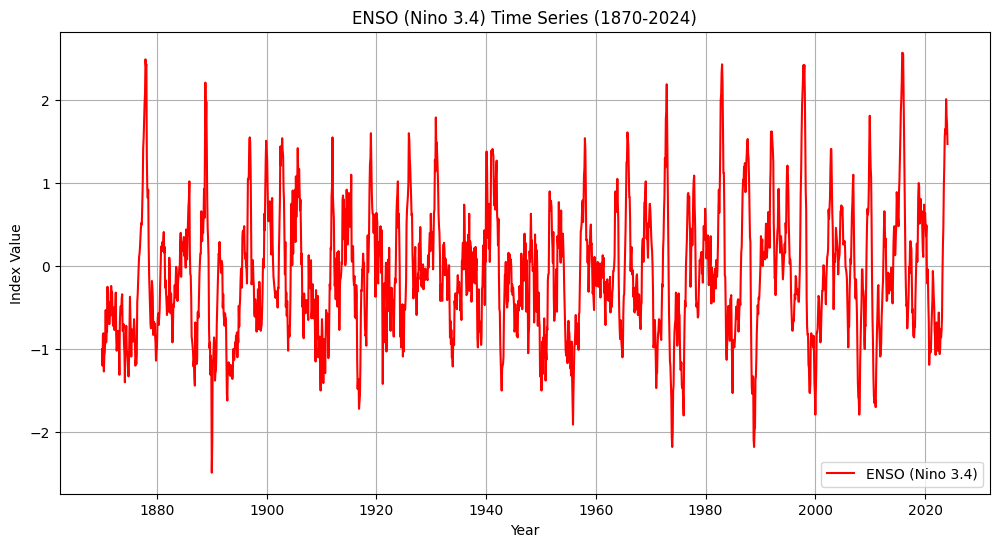

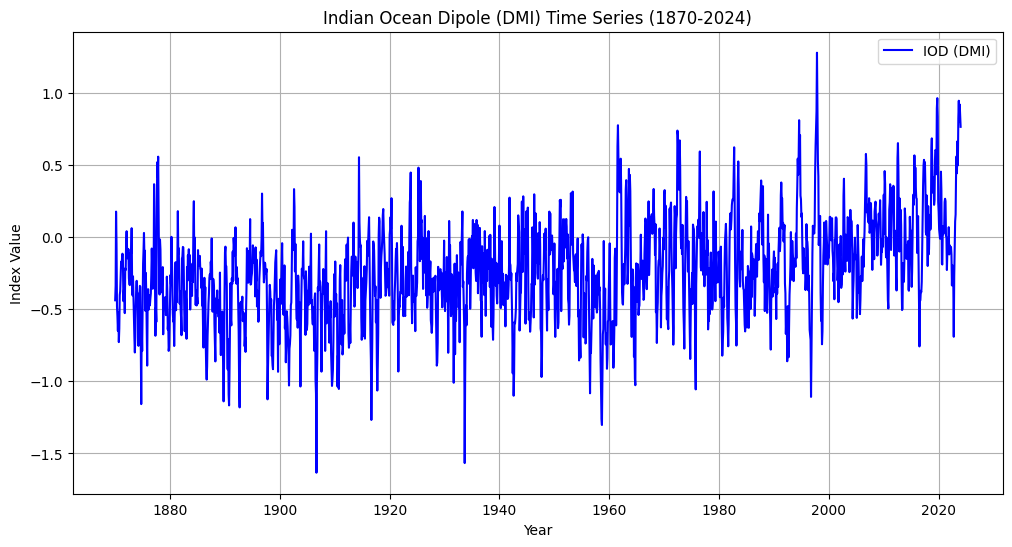

In [4]:
# Load and parse the ENSO and IOD data
nino34_series = parse_data(nino34_lines, 1870, 2024)
dmi_series = parse_data(dmi_lines, 1870, 2024)

# Plotting the ENSO and IOD time series
plt.figure(figsize=(12, 6))
plt.plot(nino34_series, label='ENSO (Nino 3.4)', color='red')
plt.title('ENSO (Nino 3.4) Time Series (1870-2024)')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dmi_series, label='IOD (DMI)', color='blue')
plt.title('Indian Ocean Dipole (DMI) Time Series (1870-2024)')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

# Question 2

In [5]:
# Compute the correlation coefficient
correlation = nino34_series.corr(dmi_series)
print("Correlation Coefficient between ENSO and IOD:", correlation)

Correlation Coefficient between ENSO and IOD: 0.3092464809719055


# Question 3

In [6]:
# Load and inspect the first few lines of the PDO and IPO data files to understand their format
pdo_path = 'pdo.long.data.txt'
ipo_path = 'tpi.timeseries.hadisst11.data.txt'

# Read and display the first few lines of each file to understand the format
with open(pdo_path, 'r') as file:
    pdo_lines = file.readlines()

with open(ipo_path, 'r') as file:
    ipo_lines = file.readlines()

In [7]:
# Refining the parsing function to handle empty or improperly formatted lines more robustly

def parse_and_smooth_data_robust(lines, start_year, end_year):
    data = []
    for line in lines[1:]:  # Skip the header line that contains the year range
        parts = line.strip().split()
        if len(parts) == 13:  # Ensure there are 1 year + 12 month values
            try:
                year = int(parts[0])
                if start_year <= year <= end_year:
                    values = [float(value) if value not in ['-9999.000.', '-9.90', '-99.000'] else np.nan for value in parts[1:]]
                    data.append([year] + values)
            except ValueError:
                continue  # Skip lines with non-numeric data
    columns = ["Year"] + [f"Month_{i+1}" for i in range(12)]
    df = pd.DataFrame(data, columns=columns)
    df.set_index("Year", inplace=True)
    # Reshape to a single time series
    df = df.stack().reset_index()
    df.columns = ["Year", "Month", "Value"]
    df['Month'] = df['Month'].str.extract(r'(\d+)').astype(int)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
    df.set_index("Date", inplace=True)
    series = df['Value']
    # Applying a 121-month rolling mean for decadal filtering
    filtered_series = series.rolling(window=121, center=True).mean()
    return series, filtered_series

# Re-parse and filter PDO and IPO data with the robust function
pdo_series_robust, pdo_filtered_robust = parse_and_smooth_data_robust(pdo_lines, 1900, 2022)
ipo_series_robust, ipo_filtered_robust = parse_and_smooth_data_robust(ipo_lines, 1900, 2022)

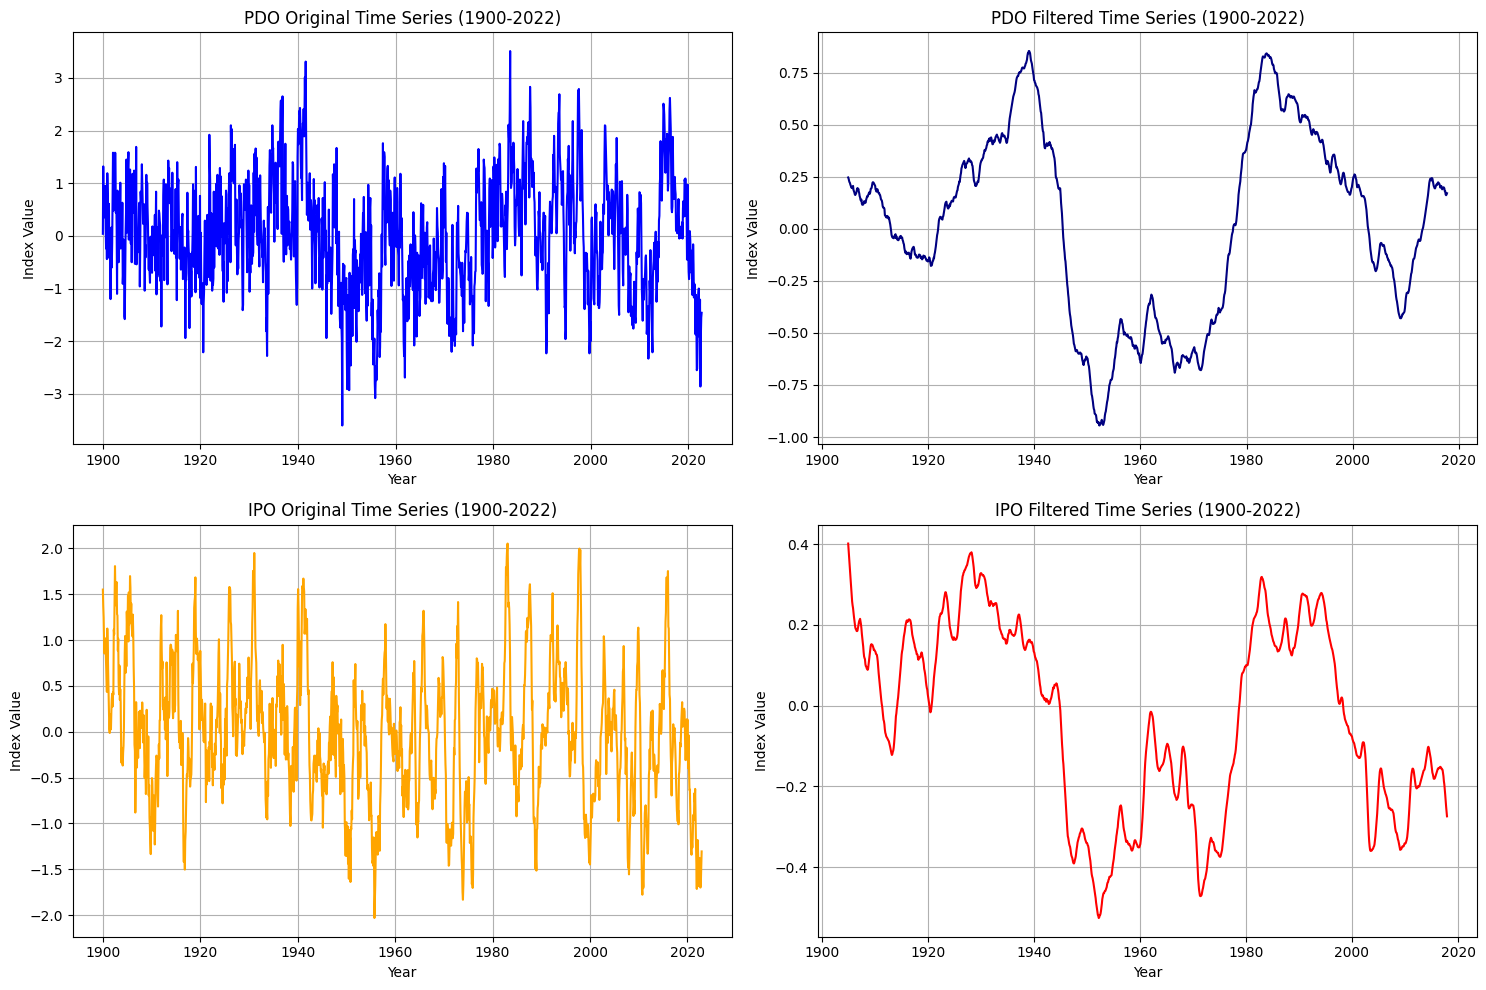

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot PDO Original
axs[0, 0].plot(pdo_series_robust, label='PDO Original', color='blue')
axs[0, 0].set_title('PDO Original Time Series (1900-2022)')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Index Value')
axs[0, 0].grid(True)

# Plot PDO Filtered
axs[0, 1].plot(pdo_filtered_robust, label='PDO Filtered', color='navy')
axs[0, 1].set_title('PDO Filtered Time Series (1900-2022)')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Index Value')
axs[0, 1].grid(True)

# Plot IPO Original
axs[1, 0].plot(ipo_series_robust, label='IPO Original', color='orange')
axs[1, 0].set_title('IPO Original Time Series (1900-2022)')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Index Value')
axs[1, 0].grid(True)

# Plot IPO Filtered
axs[1, 1].plot(ipo_filtered_robust, label='IPO Filtered', color='red')
axs[1, 1].set_title('IPO Filtered Time Series (1900-2022)')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Index Value')
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


# Question 4

In [9]:
# Load and inspect the first few lines of the pre-filtered IPO data file to understand its format
filtered_ipo_path = 'tpi.timeseries.hadisst11.filt.data.txt'

# Read and display the first few lines of the file
with open(filtered_ipo_path, 'r') as file:
    filtered_ipo_lines = file.readlines()


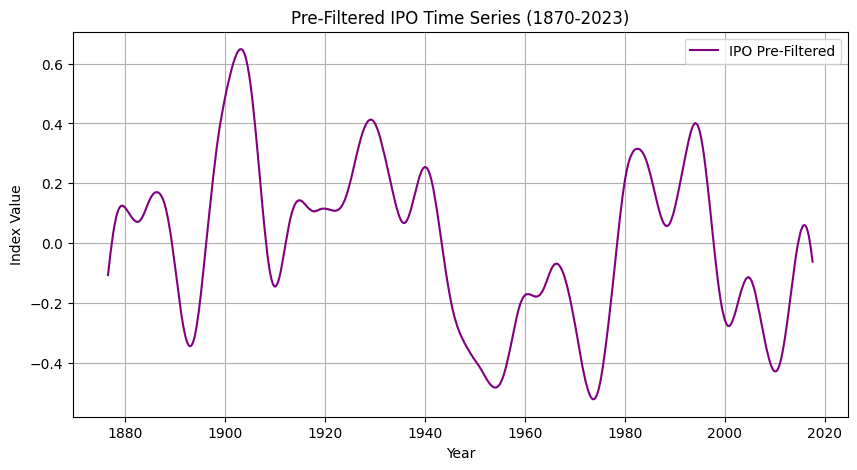

In [10]:
# Revising the parsing function to handle lines that might not conform to expected formats or contain unexpected text
def parse_pre_filtered_ipo_robust(lines, start_year, end_year):
    data = []
    for line in lines[1:]:  # Skip the first line that only contains the year range
        parts = line.strip().split()
        try:
            year = int(parts[0])
            if start_year <= year <= end_year:
                values = [float(value) if float(value) != -99.000 else np.nan for value in parts[1:]]
                data.append([year] + values)
        except ValueError:
            continue  # This skips lines with non-numeric year values or other parsing issues
    columns = ["Year"] + [f"Month_{i+1}" for i in range(12)]
    df = pd.DataFrame(data, columns=columns)
    df.set_index("Year", inplace=True)
    # Reshape to a single time series
    df = df.stack().reset_index()
    df.columns = ["Year", "Month", "Value"]
    df['Month'] = df['Month'].str.extract(r'(\d+)').astype(int)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
    df.set_index("Date", inplace=True)
    return df['Value']

# Parse the pre-filtered IPO data with the robust parsing function
filtered_ipo_series_robust = parse_pre_filtered_ipo_robust(filtered_ipo_lines, 1870, 2024)

# Plot the pre-filtered IPO data
plt.figure(figsize=(10, 5))
plt.plot(filtered_ipo_series_robust, label='IPO Pre-Filtered', color='purple')
plt.title('Pre-Filtered IPO Time Series (1870-2023)')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
correlation_coefficient = ipo_filtered_robust.corr(filtered_ipo_series_robust)

print("Correlation coefficient between Q3 and Q4: ", correlation_coefficient)

Correlation coefficient between Q3 and Q4:  0.913672896759951


# Question 5

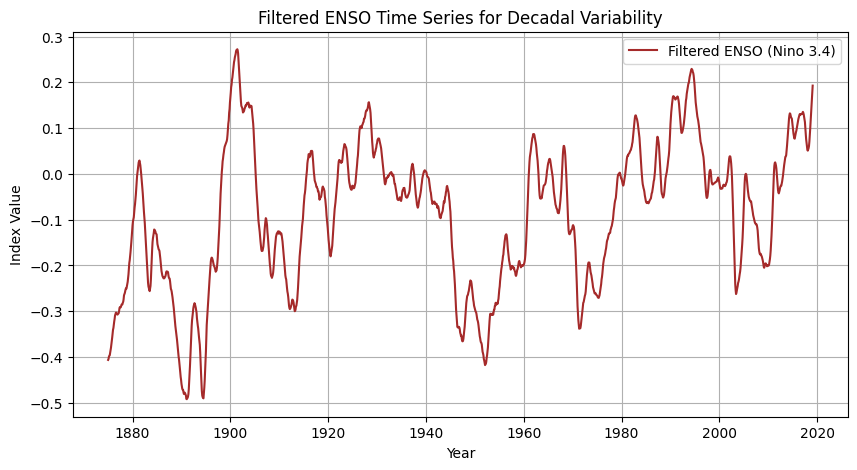

In [12]:
# Apply a 121-month running mean to the ENSO (Nino 3.4) time series for decadal filtering
enso_filtered = nino34_series.rolling(window=121, center=True).mean()

# Plot the filtered ENSO time series for visualization
plt.figure(figsize=(10, 5))
plt.plot(enso_filtered, label='Filtered ENSO (Nino 3.4)', color='brown')
plt.title('Filtered ENSO Time Series for Decadal Variability')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

In [13]:

# Compute the correlation coefficient between filtered ENSO and filtered PDO
correlation_with_pdo = enso_filtered.corr(pdo_filtered_robust)
print(f'Correlation Coefficient between Filtered ENSO and Filtered PDO: {correlation_with_pdo}')

# Compute the correlation coefficient between filtered ENSO and filtered IPO
correlation_with_ipo = enso_filtered.corr(ipo_filtered_robust)
print(f'Correlation Coefficient between Filtered ENSO and Filtered IPO: {correlation_with_ipo}')


Correlation Coefficient between Filtered ENSO and Filtered PDO: 0.6353618969650023
Correlation Coefficient between Filtered ENSO and Filtered IPO: 0.7258021884016923


# Question 6

In [14]:
# Subtract the filtered ENSO time series from the original ENSO time series to get the non-decadal component
enso_non_decadal = nino34_series - enso_filtered

# Compute correlation coefficients of the non-decadal ENSO component with the filtered ENSO, IPO, and PDO time series
correlation_non_decadal_with_filtered_enso = enso_non_decadal.corr(enso_filtered)
correlation_non_decadal_with_filtered_ipo = enso_non_decadal.corr(ipo_filtered_robust)
correlation_non_decadal_with_filtered_pdo = enso_non_decadal.corr(pdo_filtered_robust)

# Print out the correlation coefficients
correlation_non_decadal_with_filtered_enso, correlation_non_decadal_with_filtered_ipo, correlation_non_decadal_with_filtered_pdo

# Subtract the filtered ENSO time series from the original ENSO time series to get the non-decadal component
enso_non_decadal = nino34_series - enso_filtered

# Compute correlation coefficients of the non-decadal ENSO component with the filtered ENSO, IPO, and PDO time series
correlation_non_decadal_with_filtered_enso = enso_non_decadal.corr(enso_filtered)
correlation_non_decadal_with_filtered_ipo = enso_non_decadal.corr(ipo_filtered_robust)
correlation_non_decadal_with_filtered_pdo = enso_non_decadal.corr(pdo_filtered_robust)

# Print out the correlation coefficients
correlation_results = {
    "Non-Decadal ENSO with Filtered ENSO": correlation_non_decadal_with_filtered_enso,
    "Non-Decadal ENSO with Filtered IPO": correlation_non_decadal_with_filtered_ipo,
    "Non-Decadal ENSO with Filtered PDO": correlation_non_decadal_with_filtered_pdo
}

print("Non-Decadal ENSO with Filtered ENSO: ", correlation_non_decadal_with_filtered_enso)
print("Non-Decadal ENSO with Filtered IPO: ", correlation_non_decadal_with_filtered_ipo)
print("Non-Decadal ENSO with Filtered PDO: ", correlation_non_decadal_with_filtered_pdo)


Non-Decadal ENSO with Filtered ENSO:  0.0241779061710032
Non-Decadal ENSO with Filtered IPO:  0.004058216920286711
Non-Decadal ENSO with Filtered PDO:  0.005028095681873126


# Question 7

In [15]:
# Load and inspect the first few lines of the AMO data file to understand its format
amo_path = 'amon.sm.long.data'

# Read and display the first few lines of the file to understand the format
with open(amo_path, 'r') as file:
    amo_lines = file.readlines()

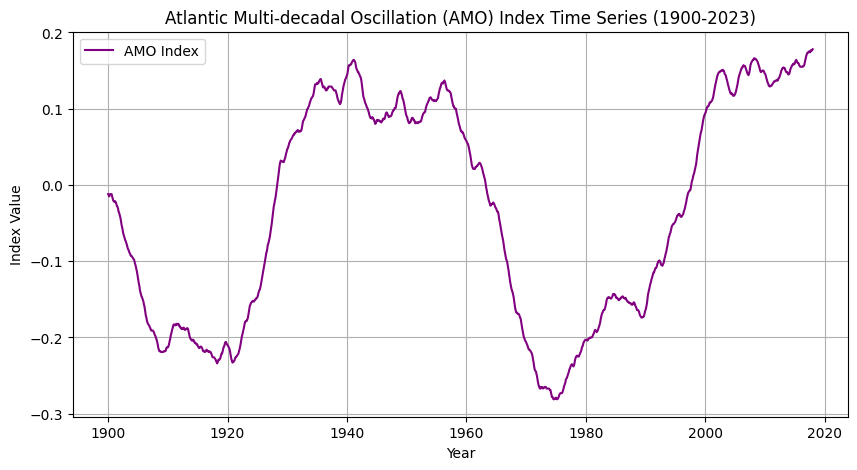

In [16]:
# Refining the parsing function to handle lines with invalid year values and retry parsing and plotting the AMO data

def parse_amo_data_refined(lines, start_year, end_year):
    data = []
    for line in lines[1:]:  # Skip the header line
        parts = line.strip().split()
        try:
            year = int(parts[0])
            if start_year <= year <= end_year:
                values = [float(value) if float(value) != -99.990 else np.nan for value in parts[1:]]
                data.append([year] + values)
        except ValueError:
            continue  # Skip lines with non-numeric or placeholder year values
    columns = ["Year"] + [f"Month_{i+1}" for i in range(12)]
    df = pd.DataFrame(data, columns=columns)
    df.set_index("Year", inplace=True)
    # Reshape to a single time series
    df = df.stack().reset_index()
    df.columns = ["Year", "Month", "Value"]
    df['Month'] = df['Month'].str.extract(r'(\d+)').astype(int)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
    df.set_index("Date", inplace=True)
    return df['Value']

# Re-parse the AMO data with refined handling
amo_series_refined = parse_amo_data_refined(amo_lines, 1900, 2023)

# Re-plot the AMO time series
plt.figure(figsize=(10, 5))
plt.plot(amo_series_refined, label='AMO Index', color='purple')
plt.title('Atlantic Multi-decadal Oscillation (AMO) Index Time Series (1900-2023)')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()


# Question 8

In [17]:
# Compute the correlation coefficients between AMO and ENSO, and AMO and IPO

# Correlation between AMO and ENSO
correlation_amo_enso = amo_series_refined.corr(nino34_series)

# Correlation between AMO and IPO (pre-filtered data used in Q4)
correlation_amo_ipo = amo_series_refined.corr(filtered_ipo_series_robust)

# Print the correlation results
correlation_amo_enso, correlation_amo_ipo

print("Correlation coefficient between AMO and ENSO (Q1): ", correlation_amo_enso)
print("Correlation coefficient between AMO and IPO (Q4): ", correlation_amo_ipo)


Correlation coefficient between AMO and ENSO (Q1):  0.019259224605013166
Correlation coefficient between AMO and IPO (Q4):  -0.21976520899819713


# Question 9

ASL736_A2.pdf